# Titanic 生存预测

In [82]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import re
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [83]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
full_data = [train, test]
PassengerId=test['PassengerId']

In [84]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 特征预处理

In [85]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [86]:
train[train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [87]:
test[test['Fare'].isnull()]


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [88]:
#1.Pclass
print( train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean() )

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


In [89]:
#2.名字
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
# If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

print(pd.crosstab(train['Title'], train['Sex']))

for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

print (train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1
    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


In [90]:
#3.年龄
for dataset in full_data:
    age_avg  = dataset['Age'].mean()
    age_std  = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
train['CategoricalAge'] = pd.cut(train['Age'], 5)

print (train[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean())

  CategoricalAge  Survived
0  (-0.08, 16.0]  0.535714
1   (16.0, 32.0]  0.349887
2   (32.0, 48.0]  0.375000
3   (48.0, 64.0]  0.434783
4   (64.0, 80.0]  0.090909


C:\Users\Jane\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [91]:
for dataset in full_data:
    age_avg  = dataset['Age'].mean()
    age_std  = dataset['Age'].std()
    print(age_avg,age_std)

29.534231200897867 13.527321747110804
30.047846889952154 13.161516741277866


In [92]:
#4.性别
print(train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean() )

      Sex  Survived
0  female  0.742038
1    male  0.188908


In [93]:
#5.家人数
for dataset in full_data:
    dataset['FamilySize']=dataset['SibSp']+dataset['Parch']+1
print( train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean() )

for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
print (train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean())

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000
   IsAlone  Survived
0        0  0.505650
1        1  0.303538


In [94]:
#6.票价
for dateset in full_data:
    dataset['Fare']=dataset['Fare'].fillna(dataset['Fare'].median())
    
    #对于像票价，年龄这种类别型较多的特征在分类问题中最好对数值做区间分段，以便分类。
    #一般只需要对train分类就可以
train['CategoricalFare'] = pd.qcut(train['Fare'], 4) #qcut是根据这些值的频率来选择箱子的均匀间隔。
print( train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean() )

   CategoricalFare  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081


In [95]:
#7.登船港口
train['Embarked']=train['Embarked'].fillna('S') 

In [96]:

print( train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean() )

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


In [97]:
train.isnull().sum()  

PassengerId          0
Survived             0
Pclass               0
Name                 0
Sex                  0
Age                  0
SibSp                0
Parch                0
Ticket               0
Fare                 0
Cabin              687
Embarked             0
Title                0
CategoricalAge       0
FamilySize           0
IsAlone              0
CategoricalFare      0
dtype: int64

In [98]:
test.isnull().sum()  

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
Title            0
FamilySize       0
IsAlone          0
dtype: int64

In [99]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,CategoricalAge,FamilySize,IsAlone,CategoricalFare
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,Mr,"(16.0, 32.0]",2,0,"(-0.001, 7.91]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,Mrs,"(32.0, 48.0]",2,0,"(31.0, 512.329]"
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,"(16.0, 32.0]",1,1,"(7.91, 14.454]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,Mrs,"(32.0, 48.0]",2,0,"(31.0, 512.329]"
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,Mr,"(32.0, 48.0]",1,1,"(7.91, 14.454]"


# 特征转化为数值

In [100]:
for dataset in full_data:
     dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int) 

In [101]:
print(train.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Sex  Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    1   22      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    0   38      1      0   
2                             Heikkinen, Miss. Laina    0   26      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    0   35      1      0   
4                           Allen, Mr. William Henry    1   35      0      0   

             Ticket     Fare Cabin Embarked Title CategoricalAge  FamilySize  \
0         A/5 21171   7.2500   NaN        S    Mr   (16.0, 32.0]           2   
1          PC 17599  71.2833   C85        C   Mrs   (32.0, 48.0]           2   
2  STON/O2. 3101282   7.9250   NaN        S  Miss   (16.0, 32.

In [102]:
#title
for dataset in full_data:
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)


In [103]:
#登船口
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)  


In [104]:
#票价
for dataset in full_data:
    dataset.loc[dataset['Fare']<=7.91,'Fare']                                   = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454),'Fare']  = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare']        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

In [105]:
#年龄
for dataset in full_data:    
    dataset.loc[ dataset['Age'] <= 16, 'Age']        = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']                           = 4

In [106]:
print(train.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Sex  Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    1    1      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    0    2      1      0   
2                             Heikkinen, Miss. Laina    0    1      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    0    2      1      0   
4                           Allen, Mr. William Henry    1    2      0      0   

             Ticket  Fare Cabin  Embarked  Title CategoricalAge  FamilySize  \
0         A/5 21171     0   NaN         0      1   (16.0, 32.0]           2   
1          PC 17599     3   C85         1      3   (32.0, 48.0]           2   
2  STON/O2. 3101282     1   NaN         0      2   (16.0, 32.0]  

In [107]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp','Parch', 'FamilySize']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)

test  = test.drop(drop_elements, axis = 1)

print (train.head(10))

train = train.values
test  = test.values  

   Survived  Pclass  Sex  Age  Fare  Embarked  Title  IsAlone
0         0       3    1    1     0         0      1        0
1         1       1    0    2     3         1      3        0
2         1       3    0    1     1         0      2        1
3         1       1    0    2     3         0      3        0
4         0       3    1    2     1         0      1        1
5         0       3    1    1     1         2      1        1
6         0       1    1    3     3         0      1        1
7         0       3    1    0     2         0      4        0
8         1       3    0    1     1         0      3        0
9         1       2    0    0     2         1      3        0
['Survived' 'Pclass' 'Sex' 'Age' 'Fare' 'Embarked' 'Title' 'IsAlone']


# 模型选择

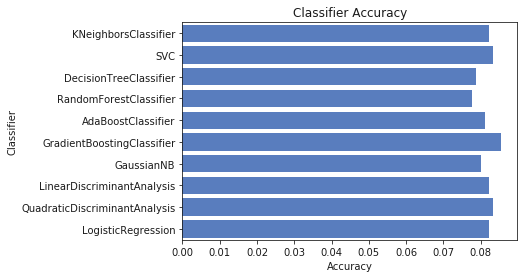

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "Accuracy"]
log  = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = train[0:, 1:]
y = train[0:, 0]

acc_dict = {}

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_train, y_train)
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    if name in acc_dict:
        acc_dict[name] += acc
    else:
        acc_dict[name] = acc

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)
     
plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

# 预测

In [ ]:
candidate_classifier = RandomForestClassifier()
candidate_classifier.fit(train[0::, 1::], train[0::, 0])
result = candidate_classifier.predict(test)

In [ ]:
print(result)

In [ ]:
submission = pd.DataFrame({"PassengerId":PassengerId ,"Survived": result})
submission.to_csv('submission.csv', index=False)

# 2 交叉验证

In [ ]:
X = train[0:, 1:]
y = train[0:, 0]
print(X)
type(X)

In [ ]:
#拆分数据成numpy.ndarray格式
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()
]

In [ ]:
name_list=[]
cv_scores_mean = []
print(len(name_list))

In [ ]:
from sklearn.model_selection import cross_val_score
for clf in classifiers:
        clf_name = clf.__class__.__name__
        name_list.append(clf_name)
        cv_scores =cross_val_score(clf,X_train,y_train,cv=3)
        cv_scores_mean.append(cv_scores.mean())

In [ ]:
log_entry = pd.DataFrame({"Classifier" : name_list,"cv_scores_mean" : cv_scores_mean})
print(log_entry.sort_values(by='cv_scores_mean',ascending=False))

In [ ]:
plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='cv_scores_mean', y='Classifier', data=log_entry, color="b")

In [ ]:
candidate_classifier = SVC()
candidate_classifier.fit(train[0:, 1:], train[0:, 0])
result = candidate_classifier.predict(test)
submission = pd.DataFrame({"PassengerId":PassengerId ,"Survived": result})
submission.to_csv('submission.csv', index=False)

# 3 参数优化

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

pipe=Pipeline([('select',SelectKBest(k=3)), 
               ('classify', RandomForestClassifier(random_state = 10, max_features = 'sqrt'))])

param_test = {'classify__n_estimators':list(range(20,50,2)), 
              'classify__max_depth':list(range(3,60,3))}
gsearch = GridSearchCV(estimator = pipe, param_grid = param_test, scoring='roc_auc', cv=10)
gsearch.fit(X,y)
print(gsearch.best_params_, gsearch.best_score_)

In [ ]:
select = SelectKBest(k = 3)
clf = RandomForestClassifier(random_state = 10, warm_start = True, 
                                  n_estimators = 26,
                                  max_depth = 6, 
                                  max_features = 'sqrt')
pipeline = make_pipeline(select, clf)
pipeline.fit(X, y)

In [ ]:
cv_score = cross_validation.cross_val_score(pipeline, X, y, cv= 10)
print("CV Score : Mean - %.7g | Std - %.7g " % (np.mean(cv_score), np.std(cv_score)))

In [ ]:
predictions = pipeline.predict(test)

In [ ]:
submission = pd.DataFrame({"PassengerId":PassengerId ,"Survived": predictions})
submission.to_csv('submission.csv', index=False)